Loss Function หรือ Cost Function คือ การคำนวน Error ว่า yhat ที่โมเดลทำนายออกมา ต่างจาก y ของจริง อยู่เท่าไร แล้วหาค่าเฉลี่ย เพื่อที่จะนำมาหา Gradient ของ Loss ขึ้นกับ Weight ต่าง ๆ ด้วย Backpropagation แล้วใช้อัลกอริทึม Gradient Descent ทำให้ Loss น้อยลง ในการเทรนรอบถัดไป

ในเคสนี้เราจะพูดถึง Loss Function สำหรับงาน Classification (Discrete ค่าไม่ต่อเนื่อง) ที่เป็นที่นิยมมากที่สุด ได้แก่ Cross Entropy Loss

* yhat เป็น Probability ที่ออกมาจากโมเดลที่ Layer สุดท้ายเป็น [Softmax Function](https://www.bualabs.com/archives/1819/what-is-softmax-function-how-to-use-softmax-function-benefit-of-softmax/)
* y เป็นข้อมูลที่อยู่ในรูปแบบ [One Hot Encoding](https://www.bualabs.com/archives/1902/what-is-one-hot-encoding-benefit-one-hot-encoding-why-one-hot-encoding-in-machine-learning/)

# 0. Import

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

# 1. Data

เราจะสร้างข้อมูลตัวอย่างขึ้นมา Dog = 0, Cat 1, Rat = 2

## y

สมมติค่า y จากข้อมูลตัวอย่าง ที่เราต้องการจริง ๆ เป็นดังนี้

In [2]:
y = tensor([0, 1, 2, 0, 0, 1, 0, 2, 2, 1])
y

tensor([0, 1, 2, 0, 0, 1, 0, 2, 2, 1])

In [3]:
n, c = len(y), y.max()+1

In [4]:
y_onehot = torch.zeros(n, c)
y_onehot[torch.arange(n), y] = 1
y_onehot

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]])

## yhat

สมมติว่า โมเดลเราทำนายออกมาได้ nn

In [5]:
yhat =  tensor([[3., 2., 1.],
                [5., 6., 2.],
                [0., 0., 5.],
                [2., 3., 1.],
                [5., 4., 3.],
                [1., 0., 3.],
                [5., 3., 2.],
                [2., 2., 4.],
                [8., 5., 3.],
                [3., 4., 0.]])

เราจะใช้ [Softmax Function จาก ep ที่แล้ว](https://www.bualabs.com/archives/1819/what-is-softmax-function-how-to-use-softmax-function-benefit-of-softmax/) แล้วเติม log เอาไว้สำหรับใช้ในขั้นตอนถัดไป

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In [6]:
def log_softmax(z):
    z = z - z.max(-1, keepdim=True)[0]
    exp_z = torch.exp(z)
    sum_exp_z = torch.sum(exp_z, -1, keepdim=True)
    return (exp_z / sum_exp_z).log()

yhat กลายเป็น Probability ของ 3 Category

In [7]:
log_softmax(yhat)

tensor([[-0.4076, -1.4076, -2.4076],
        [-1.3266, -0.3266, -4.3266],
        [-5.0134, -5.0134, -0.0134],
        [-1.4076, -0.4076, -2.4076],
        [-0.4076, -1.4076, -2.4076],
        [-2.1698, -3.1698, -0.1698],
        [-0.1698, -2.1698, -3.1698],
        [-2.2395, -2.2395, -0.2395],
        [-0.0550, -3.0550, -5.0550],
        [-1.3266, -0.3266, -4.3266]])

## argmax เปรียบเทียบ y และ yhat

argmax ใช้หาตำแหน่งที่ มีค่ามากที่สุด ในที่นี้ เราสนใจค่ามากที่สุดใน มิติที่ 1

In [8]:
yhat.argmax(1)

tensor([0, 1, 2, 1, 0, 2, 0, 2, 0, 1])

In [9]:
y

tensor([0, 1, 2, 0, 0, 1, 0, 2, 2, 1])

ตรงกัน 7 อัน

In [10]:
(yhat.argmax(1) == y).sum()

tensor(7)

# 2. Cross Entropy Loss

Cross Entropy Loss (Logistic Regression) หรือ Log Loss คือ การคำนวน Error ว่า yhat ต่างจาก y อยู่เท่าไร ด้วยการนำ Probability มาคำนวน หมายถึง ทายถูก แต่ไม่มั่นใจก็จะ Loss มาก หรือ ยิ่งทายผิด แต่มั่นใจมาก ก็จะ Loss มาก โดยคำนวนทั้ง Batch แล้วหาค่าเฉลี่ย

* p(x) มีค่าระหว่าง 0 ถึง 1 (ทำให้ผ่าน log แล้วติดลบ เมื่อเจอกับเครื่องหมายลบด้านหน้า จะกลายเป็นบวก)
* Cross Entropy Loss มีค่าระหว่าง 0 ถึง Infinity (ถ้าเป็น 0 คือไม่ Error เลย)

# 2.1 สูตร Cross Entropy Loss

เรียกว่า Negative Log Likelihood

$$ NLL = -\sum x\, \log p(x) $$

เนื่องจาก ค่า $x$ อยู่ในรูป One Hot Encoding เราสามารถเขียนใหม่ได้เป็น $-\log(p_{i})$ โดย i เป็น Index ของ y ที่เราต้องการ

## 2.2 โค้ด Negative Log Likelihood

In [11]:
# log_probs = log of probability, target = target
def nll(log_probs, target):     
    return -(log_probs[torch.arange(log_probs.size()[0]), target]).mean()

## 2.3 การใช้งาน Negative Log Likelihood

In [12]:
loss = nll(log_softmax(yhat), y)
loss

tensor(1.1524)

## 2.4 Optimize

เนื่องจาก

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

ทำให้เราแยก เศษและส่วน ออกเป็น 2 ก่อนลบกัน 

และถ้า x ใหญ่เกินไป เมื่อนำมา exp จะทำให้ nan ได้ จากสูตรด้านล่าง 

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

a คือ max(x) เราสามารถ exp(x-a) ให้ x เป็นค่าติดลบให้หมด เมื่อ exp จะได้ไม่เกิน 1 แล้วค่อยไปบวกก a กลับทีหลังได้

จาก 2 สูตรด้านบน เราสามารถ Optimize โค้ด ได้ดังนี้

In [13]:
def log_softmax2(z):    
    m = z.max(-1, keepdim=True)[0]
    return z - ((z-m).exp().sum(-1, keepdim=True).log()+m)

หรือ

In [14]:
def log_softmax3(z):    
    return z - (z).logsumexp(-1, keepdim=True)

### เปรียบเทียบผลลัพธ์กับ PyTorch

In [15]:
import torch.nn.functional as F

In [16]:
F.cross_entropy(yhat, y)

tensor(1.1524)

In [17]:
nll(log_softmax(yhat), y)

tensor(1.1524)

In [18]:
nll(log_softmax2(yhat), y)

tensor(1.1524)

In [19]:
nll(log_softmax3(yhat), y)

tensor(1.1524)

ผลลัพธ์ถูกต้อง ตรงกับ PyTorch F.cross_entropy

## 2.5 พล็อตกราฟ

เราจะสมมติว่า Dog = 0, Cat = 1 และในข้อมูลตัวอย่างมีแต่ Dog (0) อย่างเดียว เราจะลองดูว่าพล็อตกราฟไล่ตั้งแต่ ความน่าจะเป็น 0-100%

เราจะสร้างข้อมูลตัวอย่างขึ้นมา ให้ y เป็น 0 จำนวน 100 ตัว แทนรูปภาพ Dog 100 รูป เราจะได้เอาไว้พล็อตกราฟ

In [20]:
y = torch.zeros(100)
y[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

yhat คือ Output ของโมเดลว่า ความน่าจะเป็นรูป Dog (Column 0) และความน่าจะเป็นรูป Cat (Column 1) เราจะไล่ข้อมูลตั้งแต่ (หมา 0% แมว 100%) ไปยัง (หมา 100% แมว 0%)

In [21]:
yhat = torch.zeros(100, 2)
yhat[range(0, 100), 0] = torch.arange(0., 1., 0.01)
yhat[:, 1] = 1-yhat[:, 0]
yhat[:10]

tensor([[0.0000, 1.0000],
        [0.0100, 0.9900],
        [0.0200, 0.9800],
        [0.0300, 0.9700],
        [0.0400, 0.9600],
        [0.0500, 0.9500],
        [0.0600, 0.9400],
        [0.0700, 0.9300],
        [0.0800, 0.9200],
        [0.0900, 0.9100]])

คำนวนค่าความน่าจะเป็น ของทั้ง 2 Class เอาไว้พล็อตกราฟ

In [22]:
classes = torch.tensor([0., 1.])
yhat_classes = yhat @ classes.t()
yhat_classes[:10]

tensor([1.0000, 0.9900, 0.9800, 0.9700, 0.9600, 0.9500, 0.9400, 0.9300, 0.9200,
        0.9100])

Log ค่า Probability (ของจริงจะมาจาก Softmax ตามตัวอย่างด้านบน) เตรียมไว้เข้าสูตร

In [23]:
log_probs = yhat.log()
log_probs[:10]

tensor([[   -inf,  0.0000],
        [-4.6052, -0.0101],
        [-3.9120, -0.0202],
        [-3.5066, -0.0305],
        [-3.2189, -0.0408],
        [-2.9957, -0.0513],
        [-2.8134, -0.0619],
        [-2.6593, -0.0726],
        [-2.5257, -0.0834],
        [-2.4079, -0.0943]])

Negative Log Likelihood

In [24]:
loss = -(log_probs[torch.arange(log_probs.size()[0]), y.long()])
loss[:10]

tensor([   inf, 4.6052, 3.9120, 3.5066, 3.2189, 2.9957, 2.8134, 2.6593, 2.5257,
        2.4079])

### พล็อตกราฟ y, yhat, loss และ log loss

* ข้อมูลตัวอย่าง y ที่สมมติว่าเท่ากับ 0 อย่างเดียว (เส้นสีแดง) เทียบกับ yhat ที่ทำนายไล่ตั้งแต่ 1 ไปถึง 0 (ทายผิดไล่ไปถึงทายถูก เส้นสีเขียว)
* สังเกต Loss สีส้ม เริ่มจากซ้ายสุด Ground Truth เท่ากับ 0 (เส้นสีแดง) แต่โมเดลทายผิด ทายว่าเป็น 1 (เส้นสีเขียว) ด้วยความมั่นใจ 100% ทำให้ Loss พุ่งขึ้นถึง Infinity 
* เลื่อนมาตรงกลาง Loss จะลดลงอย่างรวดเร็ว เมื่อโมเดลทายผิด แต่ไม่ได้มั่นใจเต็มร้อย 
* ด้านขวา Loss ลดลงเรื่อย ๆ จนเป็น 0 เมื่อโมเดลทายถูก ว่าเป็น 0 ด้วยความมั่นใจ 100%
* Log of Loss คือเปลี่ยน Loss ที่อยู่ช่วง Infinity ถึง 0 เป็น Log Scale จะได้ช่วง Infinity ถึง -Infinity จะได้ Balance ดูง่ายขึ้น


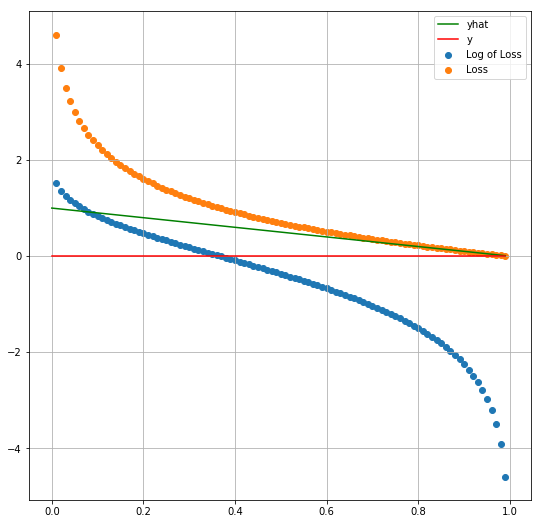

In [25]:
fig,ax = plt.subplots(figsize=(9, 9))
ax.scatter(yhat[:,0].numpy(), loss.log(), label="Log of Loss")
ax.scatter(yhat[:,0].numpy(), loss, label="Loss")
ax.plot(yhat[:,0].numpy(), yhat_classes.numpy(), label="yhat", color='green')
ax.plot(yhat[:,0].numpy(), y.numpy(), label="y", color='red')
ax.grid(True)
ax.legend(loc='upper right')

# 3. Loss Function อื่น ๆ

เราจะเป็นที่ต้องเข้าใจความเป็นมา และกลไกการทำงานภายใน ของ Loss Function เนื่องจากเมื่อเราต้องการออกแบบโมเดล ในการแก้ปัญหาที่ซับซ้อนมากขึ้น เราต้องออกแบบ Loss Function ให้เข้ากับงานนั้นด้วย เช่น อาจจะเอาหลาย ๆ Loss Function มาผสมกัน แล้ว Weight น้ำหนัก รวมเป็น Loss ที่เราต้องการ เป็นต้น